In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.spatial import Voronoi
from shapely.geometry import LineString, Polygon
from shapely.ops import polygonize

np.random.seed(0)
ox.config(use_cache=True)

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


## 1. Load census and boundary data

In [2]:
# 2016 demographic data by postcode
path_demographic_data = '../../ABSData/2016 Census GCP Postal Areas for VIC/2016Census_G01_VIC_POA.csv'
postcode_demographics = pd.read_csv(path_demographic_data)
postcode_demographics.shape

(698, 109)

In [3]:
# postcode boundaries shapefile
path_postcode_boundaries = '../../ABSData/Boundaries/POA_2016_AUST.shp'
postcode_boundaries = gpd.read_file(path_postcode_boundaries)
postcode_boundaries.shape

(2670, 5)

In [4]:
# re-project postcode_boundaries to align CRSs
postcode_boundaries = postcode_boundaries.dropna(subset=['geometry']).to_crs(ox.settings.default_crs)

## 2. Geocode service center locations

In [5]:
# geocode the addresses of 3 hospitals to lat-lng
dandenong_latlng = ox.geocode('Dandenong Hospital, Dandenong VIC 3175, Australia')
casey_latlng = ox.geocode('62-70 Kangan Dr, Berwick VIC 3806, Australia')
kingston_latlng = ox.geocode('The Kingston Centre, Heatherton VIC 3202, Australia')

# X and Y vectors of these hospitals' coordinates
hospitals = ['dandenong', 'casey', 'kingston']
X = pd.Series([dandenong_latlng[1], casey_latlng[1], kingston_latlng[1]], index=hospitals)
Y = pd.Series([dandenong_latlng[0], casey_latlng[0], kingston_latlng[0]], index=hospitals)

## 3. Combine demographics and spatial data

In [6]:
# merge demographic data with spatial boundaries
gdf = pd.merge(left=postcode_boundaries, right=postcode_demographics,
               how='right', left_on='POA_CODE', right_on='POA_CODE_2016')
gdf.shape

(698, 114)

## 4. Compute distance to each service center from each postcode

In [7]:
# extract postcode centroid lats and lngs
postcode_lng = gdf['geometry'].centroid.x
postcode_lat = gdf['geometry'].centroid.y

In [8]:
# calculate great-circle distance from each postcode to each hospital in km
for hospital in hospitals:
    col = f'dist_{hospital}'
    gdf[col] = ox.great_circle_vec(postcode_lat, postcode_lng, Y.loc[hospital], X.loc[hospital]) / 1000

In [9]:
# subset only those postcodes within 10km of any of these 3 hospitals
mask = (gdf[['dist_dandenong', 'dist_casey', 'dist_kingston']] < 10).any(axis=1)
gdf_nearby = gdf[mask]

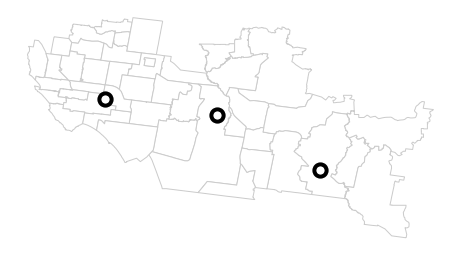

In [10]:
# plot the postcodes and hospitals
fig, ax = plt.subplots(figsize=(8,8))
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1)
ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4)
ax.axis('off')
plt.show()

## 5. Create the street network

In [11]:
# get the street network within the union of these postcodes
polygon = gdf_nearby.unary_union
G = ox.graph_from_polygon(polygon, network_type='drive')

In [12]:
# identify the nearest network nodes to each hospital
hospital_nodes = pd.Series(ox.get_nearest_nodes(G, X, Y, method='kdtree'), index=X.index)

## 6. Sample addresses

In [13]:
# sample "addresses" along the street network (in this example, nodes stand-in for true addresses)
addresses = ox.graph_to_gdfs(G, edges=False).sample(1000)

## 7. Display sampled addresses and postcodes

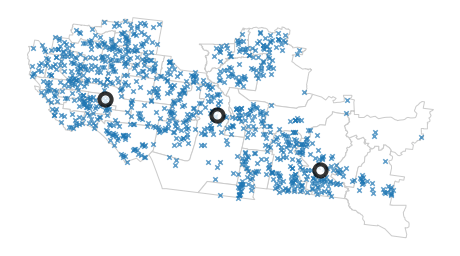

In [14]:
# plot the postcodes, hospitals, and addresses
fig, ax = plt.subplots(figsize=(8,8))
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1, alpha=1)

ax.scatter(addresses['x'], addresses['y'], marker='x', s=20, alpha=0.7)

ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4, alpha=0.8)
ax.axis('off')
plt.show()

## 8. Estimation of travel time

In [15]:
# calculate network-based distances between each address and each hospital
distances = {}
for address in addresses.index:
    distances[address] = {}
    for hospital_label, hospital_node in hospital_nodes.iteritems():
        try:
            distance = nx.shortest_path_length(G, source=address, target=hospital_node, weight='length')
        except:
            distance = None
        distances[address][hospital_label] = distance

## 9. Address-based catchment basins

In [16]:
# identify which hospital is nearest to each address
df_dists = pd.DataFrame(distances).T.dropna().astype(float)
nearest_hospital = df_dists.idxmin(axis=1)

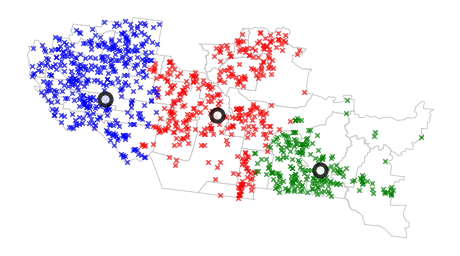

In [17]:
# plot the postcodes, hospitals, and addresses
fig, ax = plt.subplots(figsize=(8,8))
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1, alpha=1)

colors = ['g', 'r', 'b']
groups = nearest_hospital.groupby(nearest_hospital)
for (label, group), c in zip(groups, colors):
    x = addresses.loc[group.index]['x']
    y = addresses.loc[group.index]['y']
    ax.scatter(x, y, marker='x', s=20, color=c, alpha=0.7)

ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4, alpha=0.8)
ax.axis('off')
plt.show()

## 10. Polygon-based catchment basins

In [18]:
# create voronoi tessellation
vor = Voronoi(addresses[['x', 'y']])

In [19]:
# convert tessellation into regions
lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
regions = gpd.GeoDataFrame(data=polygonize(lines), columns=['geometry'], geometry='geometry')

In [20]:
# convert regions into temporary catchment basins
basins = []
labels = []

# for each group of addresses nearest to each hospital
groups = nearest_hospital.groupby(nearest_hospital)
for label, group in groups:
    
    # find all the regions that intersect their point geometries to construct a basin
    points = addresses.loc[group.index]['geometry'].unary_union
    basin = regions[regions.intersects(points)].unary_union
    
    # trim the basin to the extent of the postcodes' geometries
    basin = basin.intersection(gdf_nearby.unary_union)
    
    # if the intersection operation yielded a multipolygon, just take the largest polygon as the basin
    if not isinstance(basin, Polygon):
        basin = max(basin, key=lambda x: x.area)
    basins.append(basin)
    labels.append(label)

gdf_temp_basins = gpd.GeoDataFrame(data=basins, index=labels, columns=['geometry'], geometry='geometry')
gdf_temp_basins.crs = ox.settings.default_crs

In [21]:
# now expand the catchment basins to fill the postcodes, as tessellation alone likely won't do it
gdf_basins = gdf_temp_basins.copy()
for label in gdf_basins.index:
    
    # get this basin's geometry and the geometry of all other basins
    basin = gdf_basins.loc[label]['geometry']
    others = [l for l in gdf_basins.index if l != label]
    others_geometry = gdf_basins.loc[others, 'geometry'].unary_union
    
    # find all postcodes that intersect this basin, take union, then subtract all other basins from union
    # this expands the basin to fill the postcodes that it touches, without overlapping the other basins
    expanded_basin = gdf_nearby[gdf_nearby.intersects(basin)].unary_union.difference(others_geometry)
    
    try:
        # if the difference operation yielded a multipolygon, just take the largest polygon as the basin
        if not isinstance(expanded_basin, Polygon):
            expanded_basin = max(expanded_basin, key=lambda x: x.area)
    except:
        expanded_basin = None
    
    # add this basin to the geodataframe
    gdf_basins.loc[label] = expanded_basin

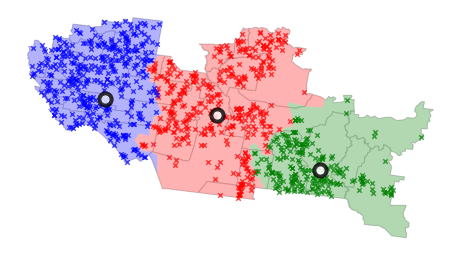

In [22]:
# plot the postcodes, hospitals, addresses, and catchment basins
fig, ax = plt.subplots(figsize=(8,8))

colors = ['g', 'r', 'b']
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1, alpha=1)
gdf_basins.plot(ax=ax, color=colors, alpha=0.3)

groups = nearest_hospital.groupby(nearest_hospital)
for (label, group), c in zip(groups, colors):
    x = addresses.loc[group.index]['x']
    y = addresses.loc[group.index]['y']
    ax.scatter(x, y, marker='x', s=20, color=c, alpha=0.7)

ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4, alpha=0.8)
ax.axis('off')
plt.show()

## 11. Estimate case load per center

Based on number of strokes per postcode, estimated in example 1, and the catchment basins created here in example 2.

In [23]:
# load estimated strokes per postcode, from example 1
strokes = pd.read_csv('data/postcode_strokes.csv')

In [24]:
# merge postcode boundaries with estimated strokes
postcodes = gdf_nearby[['POA_CODE', 'geometry']]
postcode_strokes = pd.merge(left=postcodes, right=strokes)

In [25]:
# spatial-join the sampled points to their containing postcodes and catchment basins
addresses_postcodes = gpd.sjoin(addresses, postcode_strokes, how='left', op='intersects')[['geometry', 'POA_CODE', 'strokes']]
addresses_postcodes_basins = gpd.sjoin(addresses_postcodes, gdf_basins.reset_index(), how='left', op='intersects')
addresses_postcodes_basins = addresses_postcodes_basins.rename(columns={'index':'basin'})[['POA_CODE', 'basin', 'strokes']]

# count points per postcode/basin combo and the total per postcode
counts = addresses_postcodes_basins.groupby(['POA_CODE', 'basin']).size()
index = counts.index.get_level_values(level=0)
totals = addresses_postcodes_basins.groupby(['POA_CODE']).size().reindex(index)

# calculate share of postcodes' points falling in each catchment basin, then multiply by strokes per postcode
basins_shares_of_postcodes = counts / totals.values
strokes_per_postcode = postcode_strokes.set_index('POA_CODE').reindex(index)['strokes'].values
strokes_per_basin_per_postcode = basins_shares_of_postcodes * strokes_per_postcode
strokes_per_hospital = strokes_per_basin_per_postcode.reset_index().groupby('basin').sum()[0].astype(int)

In [26]:
# estimated strokes per hospital 
strokes_per_hospital

basin
casey         297
dandenong     894
kingston     1526
Name: 0, dtype: int32

In [27]:
# relative share of estimated strokes per hospital
(strokes_per_hospital / strokes_per_hospital.sum()).round(3)

basin
casey        0.109
dandenong    0.329
kingston     0.562
Name: 0, dtype: float64